# Figure S1

Considers alternate virtual patient models in DRL evaluation.

In [48]:
import os
import sys
import json
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import to_rgb

sys.path.append("../utils")
from myUtils import convert_ode_parameters, obtain_architecture,  TreatmentListToTS, ExtractTreatmentFromDf
from LotkaVolterraModel import ExponentialModel, StemCellModel

In [49]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)
odeParamDic['K'] = odeParamDic['k']

In [50]:
def convert_to_rgb_grayscale(col):
    rgb_col = to_rgb(col)
    return tuple([(0.2989 * rgb_col[0]) + (0.5870 * rgb_col[1]) + (0.1140 * rgb_col[2]) for _ in range(3)])

def redistribute_rgb(col):
    r, g, b = col
    threshold = 1 
    m = max(r, g, b)
    if m <= threshold:
        return r, g, b
    total = r + g + b
    if total >= 3 * threshold:
        return threshold, threshold, threshold
    x = (3 * threshold - total) / (3 * m - total)
    gray = threshold - x * m
    return (gray + x * r), (gray + x * g), (gray + x * b)

/tmp/ipykernel_1177313/2990576886.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([''] + list(colors.keys()));


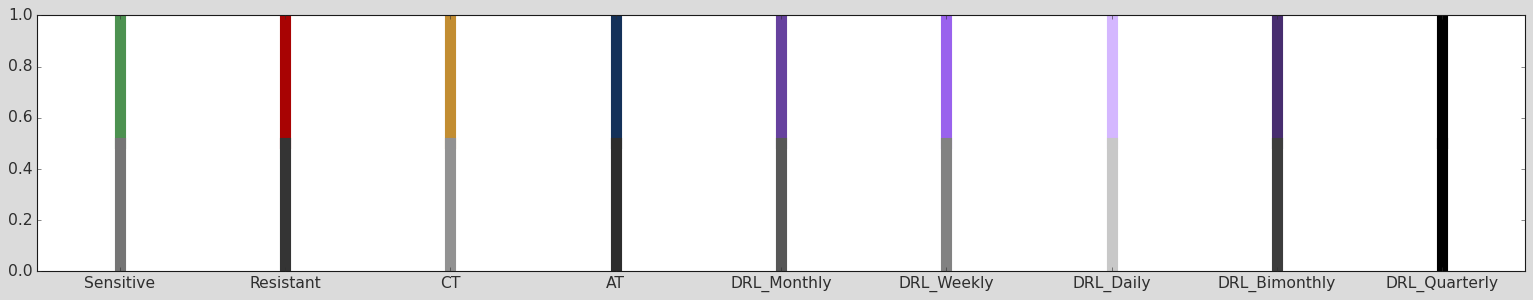

In [51]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

colors['DRL_Weekly'] = redistribute_rgb(tuple([1.5 * x for x in to_rgb(colors['DRL_Monthly'])]))
colors['DRL_Daily'] = redistribute_rgb(tuple([2.0 * x for x in to_rgb(colors['DRL_Monthly'])]))

colors['DRL_Bimonthly'] = redistribute_rgb(tuple([0.7 * x for x in to_rgb(colors['DRL_Monthly'])]))
colors['DRL_Quarterly'] = redistribute_rgb(tuple([0 * x for x in to_rgb(colors['DRL_Monthly'])]))

fig, ax = plt.subplots(1, 1, figsize=(24, 4))
for i, col in enumerate(colors.values()):
    plt.axvline(i+1, 0.5, 1, color = col, linewidth=10)
    plt.axvline(i+1, 0, 0.5, color = convert_to_rgb_grayscale(col), linewidth=10)
plt.xlim(0.5, len(colors.values()) + 0.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().set_xticklabels([''] + list(colors.keys()));

## Panel A - Robustness to changes in model (growth law)?

In [52]:
def calc_ttp(results_df):
    ttp_list = []
    for id in results_df.ReplicateId.unique():
        ttp_list.append(max(results_df['Time'][results_df['ReplicateId']==id]))
    return ttp_list

def PlotDrug(dataDf, ax, color, plotDrugAsBar=True, currDrugBarPosition = 1.2, drugBarHeight = 0.2, line_max=None, **kwargs):
    # Generate drug data as time series from list
    drugConcentrationItem = TreatmentListToTS(treatmentList=ExtractTreatmentFromDf(dataDf),
                                                    tVec=dataDf['Time'])
    try:
        drugConcentrationVec += drugConcentrationItem
        max_dose = max(max_dose, np.max(drugConcentrationItem))
    except UnboundLocalError:
        drugConcentrationVec = drugConcentrationItem
        max_dose = np.max(drugConcentrationItem)

    # Plot as bars across top of plot. Cleaner, but can be harder to see alignment with tumour trajectory.
    # Rescale to make it fit within the bar at the top of the plot
    drugConcentrationVec = drugConcentrationVec * drugBarHeight + currDrugBarPosition
    line_max = dataDf['Time'].max() if line_max is None else line_max
    ax.fill_between(x=dataDf['Time'], y1=currDrugBarPosition, y2=drugConcentrationVec, linewidth=0.0,
                     alpha=0.5, step="post", label="Drug Concentration", color=color, **kwargs)
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition, linewidth=3, color="black")
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition + drugBarHeight, linewidth=3, color="black")

def Plot_method(df, legend=False, drug_label="Drug Concentration",
         ax=None, linewidth=5, drug_limit = None, drug_bar_pos = 1.3, colors = None, **kwargs):
    if ax is None: fig, ax = plt.subplots(1, 1)
    linestyles = ['-', '--', '--']
    for i, var in enumerate(["TumourSize", 'S', 'R']):
        ax.plot(df['Time'], df[var], linewidth=linewidth, linestyle=linestyles[i], color=colors[var], **kwargs)

    PlotDrug(df, ax, 'k', plotDrugAsBar = True, line_max=drug_limit, currDrugBarPosition = drug_bar_pos)
    ax.hlines(xmin=0, xmax=max(df['Time']), y=1, linestyles=":", linewidth=6, color='grey')
    ax.hlines(xmin=0, xmax=max(df['Time']), y=ax.get_ylim()[1], linestyles=":", linewidth=6, color='grey')

    # Format the plot
    ax.set_title(kwargs.get('title', ''))
    ax.set_xlim(0, max(df.Time)); ax.set_ylim(0, drug_bar_pos + 0.2)
    ax.yaxis.get_major_ticks()[-2].set_visible(False); ax.yaxis.get_major_ticks()[-1].set_visible(False); 
    ax.tick_params(right = False, top = False)
    plt.tight_layout()

In [53]:
# Notebook params
file_path = os.path.dirname(os.path.abspath("__file__"))
model_path = os.path.join(os.pardir, file_path, "models")
results_path = os.path.join(file_path, "data", "Fig4")
runFromScratch = True

model_name = 'test_currSizeOnly_pCR_monthly'; n_epochs = 140000
model_name = 'test_currSizeOnly_p25_step2_weekly'; n_epochs = 120000
updating_interval = 7
n_replicates = 100

ode_models = [ExponentialModel]
expParamDic = {'rS': 0.00715, 'rR': 0.023, 'Ks': 1, 'Kr': 0.25, 'dDs': 2, 'dDr': 0, 'S0': 0.8, 'R0':2.5e-5, 'DMax':1, 'alpha':1, 'gamma':0.0021, 'n0': 0.8+2.5e-5}
params = [expParamDic]

In [54]:
DRL_env = "/Users/galla/miniconda3/envs/DRL_env_tf15/python"  # Laptop
DRL_env = "/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python"  # Desktop

for n, ode_model in enumerate(ode_models):
    currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d_%s.csv'%(model_name,n_epochs, updating_interval, str(ode_model()))
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**params[n],'PatientId':0}]).to_dict(),
              'architecture_kws':obtain_architecture(model_name), 'ODE_model':str(ode_model()),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        param_dir = os.path.join(file_path, "data", "Fig4", "params", "params_pCR_%s_%s_%s.json"%(n_epochs, updating_interval, str(ode_model())))
        with open(param_dir, "w") as outfile:
            json.dump(argDic, outfile)
            print("Printed to JSON")
        command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig4/params/params_pCR_%s_%s_%s.json"%(n_epochs, updating_interval, str(ode_model()))
        # p = subprocess.run(command, capture_output=True, shell=True)
        print(command)

        # Load results and process them
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
            ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d_%s.csv"%(model_name,n_epochs, updating_interval, str(ode_model()))))
    else:
        # Load results
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d_%s.csv"%(model_name,n_epochs, updating_interval, str(ode_model()))), index_col=0)
        

Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig4/params/params_pCR_120000_7_ExponentialModel.json


Mean TTP for model ExponentialModel is 1507 \pm 4 days


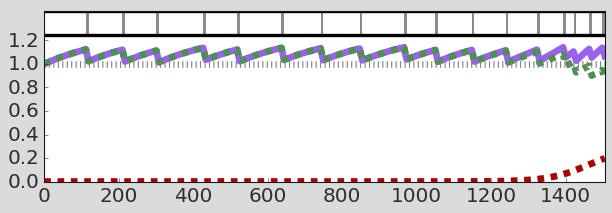

In [55]:
plt.rcParams['font.size'] = '18'

colors["DRL_LotkaVolterraModel"] = colors["DRL_Monthly"]
colors["DRL_ExponentialModel"] = "#c7308f"

for n, ode_model in enumerate(ode_models):
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d_%s.csv'%(model_name,n_epochs, updating_interval, str(ode_model()))
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= params[n]['n0']
    currDataDf = currDataDf[currDataDf.R < 0.8 * params[n]['Kr']]
    currDataDf['DrugConcentration'] = currDataDf['Action'].apply(lambda x: 1 if x == 'T' else 0) # Corrects drug conc based on treatment record
    # Plot example trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,3))
    palette = {"TumourSize": colors["DRL_Weekly"], "S": colors["Sensitive"], "R": colors["Resistant"]}
    Plot_method(currDataDf[currDataDf.ReplicateId == 2], linewidth = 6, colors = palette, ax=ax, drug_bar_pos = 1.25)
    drl_ttp = max(currDataDf[currDataDf.ReplicateId == 2].Time)
    
    # ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["AT"], zorder=0)
    # ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)

    ax.tick_params(right = False, top = False);
    plt.savefig("figures/figSI2_pCR_%s.pdf"%str(ode_model()))
    
    print(f"Mean TTP for model {ode_model()} is {np.mean(calc_ttp(currDataDf)):.0f} \pm {np.std(calc_ttp(currDataDf)):.0f} days")

Mean TTP under Adaptive Therapy is 1119 days


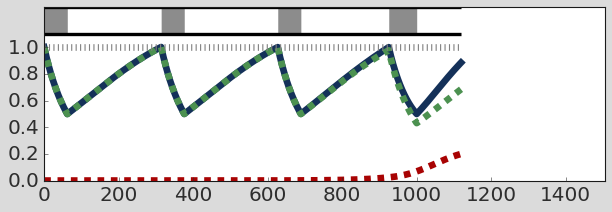

In [56]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = ExponentialModel(method='RK45', dt = 1)
model.SetParams(**expParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=2000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= expParamDic['n0']
model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * expParamDic['Kr']]

print(f"Mean TTP under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")


palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
Plot_method(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6, drug_bar_pos = 1.1)

ax.set_xlim(0, max([max(model.resultsDf.Time), drl_ttp])); ax.set_ylim(0, 1.3)
plt.savefig("figures/figSI2_AT.pdf")

## Modified growth properties

In Lu 2022, this model was parameterised with $\alpha = 1$, however we need not restrict this analysis to that value of $\alpha$.

In [57]:
ode_models = [ExponentialModel, ExponentialModel]
expParamDic_suba = expParamDic.copy(); expParamDic_suba['alpha'] = 1/2
expParamDic_supera = expParamDic.copy(); expParamDic_supera['alpha'] = 2
params = [expParamDic_suba, expParamDic_supera]

n_replicates = 10

In [58]:
for n, ode_model in enumerate(ode_models):
    alpha = params[n]['alpha']
    currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d_%s_a_%d.csv'%(model_name,n_epochs, updating_interval, str(ode_model()), params[n]['alpha'])
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**params[n],'PatientId':0}]).to_dict(),
              'architecture_kws':obtain_architecture(model_name), 'ODE_model':str(ode_model()),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        param_dir = os.path.join(file_path, "data", "Fig4", "params", "params_pCR_%s_%s_%s_a_%d.json"%(n_epochs, updating_interval, str(ode_model()), params[n]['alpha']))
        with open(param_dir, "w") as outfile:
            json.dump(argDic, outfile)
            print("Printed to JSON")
        command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig4/params/params_pCR_%s_%s_%s_a_%d.json"%(n_epochs, updating_interval, str(ode_model()), params[n]['alpha'])
        # p = subprocess.run(command, capture_output=True, shell=True)
        print(command)

        # Load results and process them
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
            ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d_%s_a_%d.csv"%(model_name,n_epochs, updating_interval, str(ode_model()), params[n]['alpha'])))
    else:
        # Load results
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d_%s_a_%d.csv"%(model_name,n_epochs, updating_interval, str(ode_model()), params[n]['alpha'])), index_col=0)

Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig4/params/params_pCR_120000_7_ExponentialModel_a_0.json
Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig4/params/params_pCR_120000_7_ExponentialModel_a_2.json


Mean TTP for model ExponentialModel with alpha = 0.5 is 1736 \pm 0 days
Mean TTP for model ExponentialModel with alpha = 2 is 1509 \pm 6 days


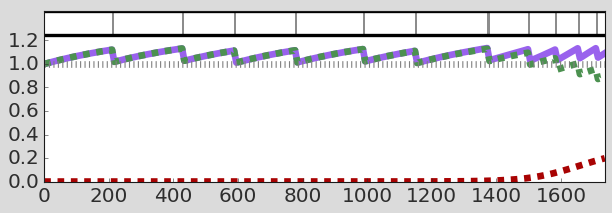

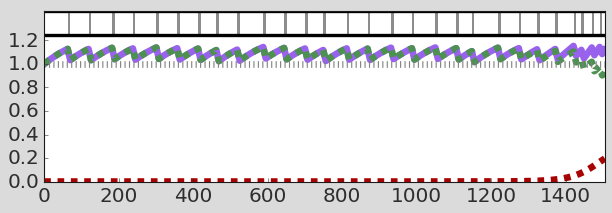

In [59]:
plt.rcParams['font.size'] = '18'

colors["DRL_LotkaVolterraModel"] = colors["DRL_Monthly"]
colors["DRL_ExponentialModel"] = "#c7308f"

for n, ode_model in enumerate(ode_models):
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d_%s_a_%d.csv'%(model_name,n_epochs, updating_interval, str(ode_model()), params[n]['alpha'])
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= params[n]['n0']
    currDataDf = currDataDf[currDataDf.R < 0.8 * params[n]['Kr']]
    currDataDf['DrugConcentration'] = currDataDf['Action'].apply(lambda x: 1 if x == 'T' else 0) # Corrects drug conc based on treatment record
    # Plot example trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,3))
    palette = {"TumourSize": colors["DRL_Weekly"], "S": colors["Sensitive"], "R": colors["Resistant"]}
    Plot_method(currDataDf[currDataDf.ReplicateId == 2], linewidth = 6, colors = palette, ax=ax, drug_bar_pos = 1.25)
    drl_ttp = max(currDataDf[currDataDf.ReplicateId == 2].Time)
    
    # ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["AT"], zorder=0)
    # ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)

    ax.tick_params(right = False, top = False);
    # plt.savefig("figures/figSI2_pCR_%s_a_%d.pdf"%(str(ode_model()), params[n]['alpha']))
    
    print(f"Mean TTP for model {ode_model()} with alpha = {params[n]['alpha']} is {np.mean(calc_ttp(currDataDf)):.0f} \pm {np.std(calc_ttp(currDataDf)):.0f} days")

Mean TTP under Adaptive Therapy for Exponential Model with alpha = 2 is 1431 days
Mean TTP under Adaptive Therapy for Exponential Model with alpha = 2 is 933 days


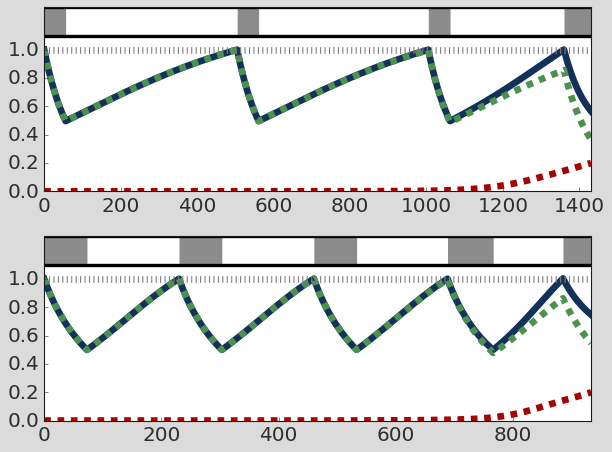

In [60]:
fig, axs = plt.subplots(2,1,figsize=(8,6))

for i, param_set in enumerate(params):
    model = ExponentialModel(method='RK45', dt = 1)
    model.SetParams(**param_set)
    model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=2000)
    model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= expParamDic['n0']
    model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * expParamDic['Kr']]

    print(f"Mean TTP under Adaptive Therapy for Exponential Model with alpha = {params[n]['alpha']} is {max(model.resultsDf.Time):.0f} days")

    palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
    Plot_method(model.resultsDf, ax=axs[i], legend=False, colors = palette, linewidth = 6, drug_bar_pos = 1.1)

    ax.set_xlim(0, max([max(model.resultsDf.Time), drl_ttp])); ax.set_ylim(0, 1.3)

## Stem-Cell Model

Alternate model by Brady-Nicholls et al., for metastatic castration-resistant prostate cancer, presented [here](https://doi.org/10.1016/j.neo.2021.06.013). Based on stem-like and differentiated cells, also accounting for a measuring delay in PSA (such that it is not exactly correlated with total tumor size).

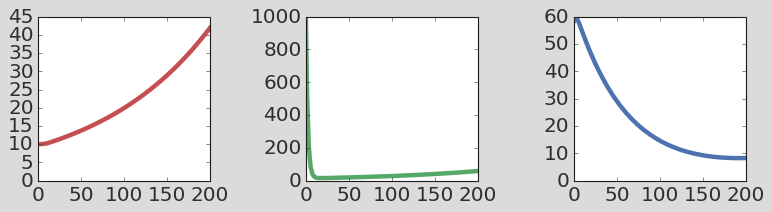

In [61]:
# Default
stemParamDic = {'lambda': np.log(2),'ps': 1e-6, 'alpha': 0.07,  # Cell params
                'rho': 0.0001, 'varphi': 0.01, 'txa': 1,  # PSA/Drug params
                'S0': 10, 'D0': 1000, 'P0': 29}  # Initial conditions

# Patient 1002
stemParamDic = {'lambda': np.log(2),'ps': 0.0257, 'alpha': 0.4852,  # Cell params
                'rho': 0.0025, 'varphi': 0.0167, 'txa': 1,  # PSA/Drug params
                'S0': 10, 'D0': 1000, 'P0': 58.57}  # Initial conditions

# The governing equations - no variable substitution
def ModelEqns(t, uVec):
    S, D, P = uVec
    dudtVec = np.zeros_like(uVec)
    dudtVec[0] = (S / (S + D)) * stemParamDic['ps'] * stemParamDic['lambda'] * S
    dudtVec[1] = (1 - (S / (S + D)) * stemParamDic['ps']) * stemParamDic['lambda'] * S - stemParamDic['alpha'] * stemParamDic['txa'] * D
    dudtVec[2] = stemParamDic['rho'] * D - stemParamDic['varphi'] * P
    return (dudtVec)

sol = sc.integrate.solve_ivp(ModelEqns, y0=[10, 1000, 58.57], t_span=(0, 200), method='RK45')

fig, axs = plt.subplots(1,3,figsize=(10,3))
for i in range(3):
    axs[i].plot(sol.t, sol.y[i], color = ['r', 'g', 'b'][i], linewidth=4); axs[i].set_ylim(bottom=0)
plt.tight_layout()

In [62]:
# Patient 1002 - TTP ~ 3000 days
stemParamDic2 = {'rR': np.log(2),'beta': 0.025, 'dR': 0.4852,  # Cell params
                'rho': 0.0025, 'phi': 0.0167, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 58.57}  # Initial conditions

In [63]:
# Patient 1005 - TTP ~ 3000 days
stemParamDic5 = {'rR': np.log(2),'beta': 0.0276, 'dR': 0.3205,  # Cell params
                'rho': 0.0016, 'phi': 0.0068, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 95.86}  # Initial conditions

In [64]:
# Patient 1010 - TTP ~ 300 days
stemParamDic10 = {'rR': np.log(2),'beta': 0.3332, 'dR': 0.0958,  # Cell params
                'rho': 6.548e-5, 'phi': 0.0028, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 17.33}  # Initial conditions

In [65]:
# Patient 1014 - TTP ~ 2000 days
stemParamDic14 = {'rR': np.log(2),'beta': 0.0425, 'dR': 0.0478,  # Cell params
                'rho': 1.243e-04, 'phi': 0.0113, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 11.83}  # Initial conditions

In [66]:
# Patient 1018 - TTP ~ 800 days
stemParamDic18 = {'rR': np.log(2),'beta': 0.1208, 'dR': 0.2083,  # Cell params
                'rho': 4.931e-04, 'phi': 0.0149, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 36.54}  # Initial conditions

Mean TTP for Stem Cell Model under Adaptive Therapy is 2123 days


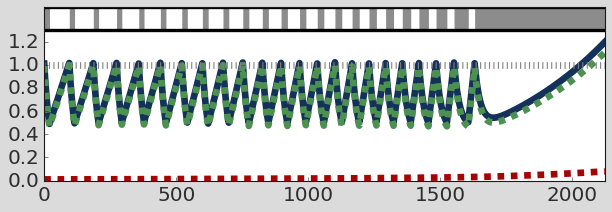

In [113]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
stemParamDic = stemParamDic14

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
Plot_method(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6, drug_bar_pos = 1.3)

# plt.savefig("figures/figSI_SC_AT.pdf")

Mean TTP for Stem Cell Model under Continuous Therapy is 1095 days


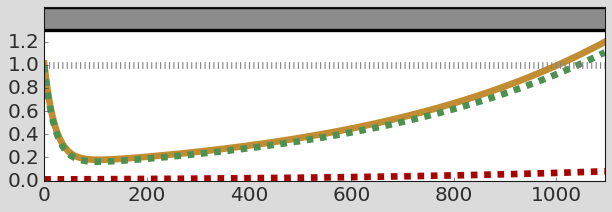

In [114]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.95, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
Plot_method(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6, drug_bar_pos = 1.3)

# plt.savefig("figures/figSI_SC_AT.pdf")

In [138]:
updating_interval = 2

In [139]:
ode_models = [StemCellModel]; params = [stemParamDic]

for param in params:
    param['n0'] = param['S0'] + param['R0']

for n, ode_model in enumerate(ode_models):
    currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d_%s.csv'%(model_name,n_epochs, updating_interval, str(ode_model()))
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**params[n],'PatientId':0}]).to_dict(),
              'architecture_kws':obtain_architecture(model_name), 'ODE_model':str(ode_model()),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        param_dir = os.path.join(file_path, "data", "Fig4", "params", "params_pCR_%s_%s_%s.json"%(n_epochs, updating_interval, str(ode_model())))
        with open(param_dir, "w") as outfile:
            json.dump(argDic, outfile)
            print("Printed to JSON")
        command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig4/params/params_pCR_%s_%s_%s.json"%(n_epochs, updating_interval, str(ode_model()))
        # p = subprocess.run(command, capture_output=True, shell=True)
        print(command)

        # Load results and process them
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
            ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d_%s.csv"%(model_name,n_epochs, updating_interval, str(ode_model()))))
    else:
        # Load results
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d_%s.csv"%(model_name,n_epochs, updating_interval, str(ode_model()))), index_col=0)
        

Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig4/params/params_pCR_120000_2_StemCellModel.json


       Unnamed: 0 Action  DrugConcentration  PatientId         R  ReplicateId  \
14209       14209      T                0.0          0  0.042769            9   
14210       14210      H                1.0          0  0.042863            9   
14211       14211      T                0.0          0  0.042958            9   
14212       14212      H                1.0          0  0.043052            9   
14213       14213      H                0.0          0  0.043146            9   

              S  Support_Hol  Support_Treat  Time  TumourSize  
14209  1.121853     0.001253       0.998747  2882    1.176558  
14210  1.076088     0.564993       0.435007  2884    1.130891  
14211  1.135480     0.000162       0.999838  2886    1.190383  
14212  1.088723     0.152033       0.847967  2888    1.143727  
14213  1.148378     0.152033       0.847967  2890    1.203483  
0.9999595880508424
Mean TTP for model StemCellModel is 2841 \pm 102 days


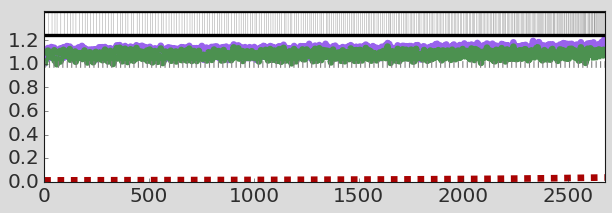

In [140]:
plt.rcParams['font.size'] = '18'

colors["DRL_LotkaVolterraModel"] = colors["DRL_Monthly"]
colors["DRL_ExponentialModel"] = "#c7308f"

for n, ode_model in enumerate(ode_models):
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d_%s.csv'%(model_name,n_epochs, updating_interval, str(ode_model()))
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= params[n]['n0']
    print(currDataDf.tail())
    print(max(currDataDf.Support_Treat))
    # currDataDf = currDataDf[currDataDf.TumourSize < 1.2]
    currDataDf['DrugConcentration'] = currDataDf['Action'].apply(lambda x: 1 if x == 'T' else 0) # Corrects drug conc based on treatment record
    # Plot example trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,3))
    palette = {"TumourSize": colors["DRL_Weekly"], "S": colors["Sensitive"], "R": colors["Resistant"]}
    Plot_method(currDataDf[currDataDf.ReplicateId == 2], linewidth = 6, colors = palette, ax=ax, drug_bar_pos = 1.25)
    drl_ttp = max(currDataDf[currDataDf.ReplicateId == 2].Time)
    
    # ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["AT"], zorder=0)
    # ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)

    ax.tick_params(right = False, top = False);
    plt.savefig("figures/figSI2_pCR_%s.pdf"%str(ode_model()))
    
    print(f"Mean TTP for model {ode_model()} is {np.mean(calc_ttp(currDataDf)):.0f} \pm {np.std(calc_ttp(currDataDf)):.0f} days")